# Working with Diagrams
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).


## Overview

The [Modeling Dynamical Systems](./dynamical_systems.ipynb) tutorial gave a very basic introduction to Drake's Systems framework, including how to assemble multiple systems into a `Diagram`. In this notebook we'll provide a more advanced/complete overview of working with diagrams.

Block diagrams are the standard modeling abstraction in systems theory and control. They provide powerful abstractions for writing modular code describing potentially very complicated dynamical systems.

In [ ]:
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.examples import PendulumPlant
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import Diagram, DiagramBuilder, LeafSystem
from pydrake.systems.primitives import AffineSystem, LogVectorOutput

## Building and visualizing your Diagram

Let's start by revisiting the `Diagram` example from the [introductory tutorial](./dynamical_systems.ipynb).

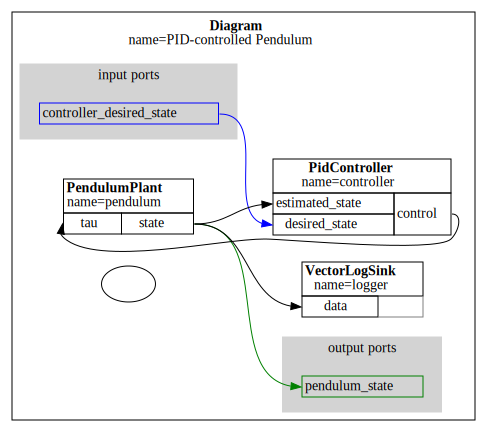

In [ ]:
def MakePidControlledPendulum():
    # Use a DiagramBuilder to add and connect the subsystems.
    builder = DiagramBuilder()

    # First add the pendulum.
    pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

    # Add a PID controller.
    controller = builder.AddNamedSystem("controller",
                                        PidController(kp=[10.], ki=[1.], kd=[1.]))

    # Now "wire up" the controller to the plant.
    builder.Connect(pendulum.get_state_output_port(),
                    controller.get_input_port_estimated_state())
    builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

    # Make the desired_state input of the controller an input to the diagram.
    builder.ExportInput(controller.get_input_port_desired_state())
    # Make the pendulum state an output from the diagram.
    builder.ExportOutput(pendulum.get_state_output_port())

    # Log the state of the pendulum.
    logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
    logger.set_name("logger")

    pid_controlled_pendulum = builder.Build()
    pid_controlled_pendulum.set_name("PID-controlled Pendulum")

    return pid_controlled_pendulum, pendulum

pid_controlled_pendulum, pendulum = MakePidControlledPendulum()

# Visualize the diagram.
display(
    SVG(
        pydot.graph_from_dot_data(
            pid_controlled_pendulum.GetGraphvizString(
                max_depth=2))[0].create_svg()))


### You can only add a System to one DiagramBuilder.

One thing that is important to understand is that when you add a system to a builder, the builder takes ownership of that system.  You cannot add the same system to another builder. Currently, Drake will report a somewhat generic error about ownership of the C++ object:

In [ ]:
second_builder = DiagramBuilder()

try:
    second_builder.AddSystem(pendulum)
except RuntimeError as err:
    print(err)

C++ object must be owned by pybind11 when attempting to release to C++


This is conceptually straightforward, but it can happen easily in jupyter notebooks. If you define a system in one cell, and add it to a builder in a second cell, then running that second cell twice in a row will cause an error. For this reason, the recommended workflow is to construct the system and add it to the builder immediately (in the same cell), or to use a function to build the system, as we've done above.

## Nested diagrams

Diagrams are Systems, too, and can be used as subsystems to achieve modularity and encapsulation.  Imagine I want to use the same PID-controlled pendulum in another context, but want to shift the coordinate system by $\pi$.  I could achieve that by adding more systems around the controlled pendulum.

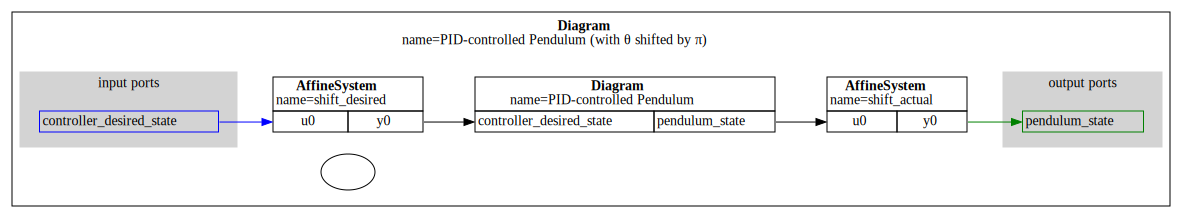

In [ ]:
builder = DiagramBuilder()

# We make the PID-controlled pendulum again here, to avoid C++ ownership issues.
pid_controlled_pendulum, pendulum = MakePidControlledPendulum()
builder.AddSystem(pid_controlled_pendulum)

# Shift desired theta by PI with the system y= u + [pi;0]
shift_desired = builder.AddNamedSystem(
    "shift_desired", AffineSystem(D=np.eye(2), y0=[np.pi, 0]))
builder.ExportInput(shift_desired.get_input_port(),
                    "controller_desired_state")

# Connect the shift to the *exported input port* from the subdiagram.
builder.Connect(shift_desired.get_output_port(),
                pid_controlled_pendulum.get_input_port())

# Shift actual theta by -PI.
shift_actual = builder.AddNamedSystem(
    "shift_actual", AffineSystem(D=np.eye(2), y0=[-np.pi, 0]))
builder.Connect(pid_controlled_pendulum.get_output_port(),
                shift_actual.get_input_port())
builder.ExportOutput(shift_actual.get_output_port(), "pendulum_state")

diagram = builder.Build()
diagram.set_name("PID-controlled Pendulum (with θ shifted by π)")

# Visualize the diagram (max depth=1)
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(max_depth=1))[0].create_svg()))


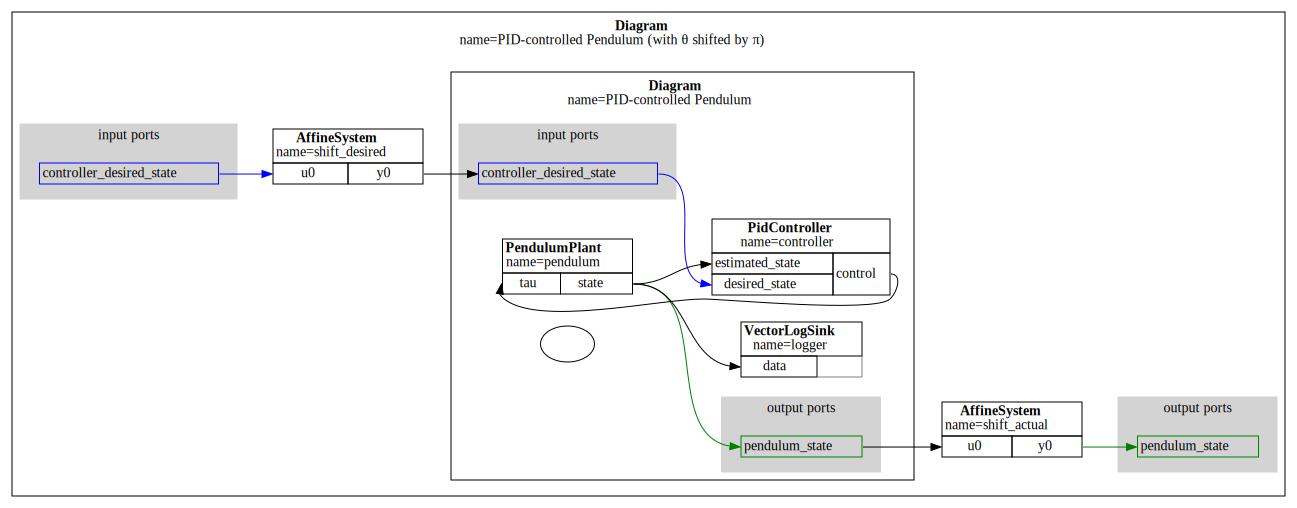

In [ ]:
# Visualize the diagram (max depth=2)
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(max_depth=2))[0].create_svg()))


## Subsystems and contexts

Now that we have a `Diagram`, we can work directly with it's `Context`. But depending on the order of e.g. the state variables in the diagrams' `Context` can be brittle (they may change if you add more systems to the `DiagramBuilder`). Moreover, the individual subsystems might provide methods that help you work with its `Context`.

The pointers returned from `DiagramBuilder::AddSystem()`/`AddNamedSystem()` are still valid pointers to the subsystem, and can be used directly. In addition, the `Diagram` provides mechanisms for retrieving pointers to the subsystems that it contains.

In [ ]:
assert(pid_controlled_pendulum.GetSubsystemByName("pendulum") == pendulum)

More interesting is the subsystem `Context`s. You should understand that a diagram's `Context` is just an organized collection of the subsystem's `Context`s. You can access those subsystem `Context`s directly, most often using [`GetMyContextFromRoot()`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_system.html#ae7fa91d2b2102457ced3361207724e52). Note that since diagrams can be subsystems in other diagrams, this method will recurse through the potentially nested diagram to recover the correct sub-`Context`.

In this example, the `Context`s are nested just like the diagram:
```
  PID-controlled Pendulum (with θ shifted by π) Context (of a Diagram)
    ↳ PID-controlled Pendulum Context (of a Diagram)
        ↳ pendulum Context
        ↳ controller Context
```

In [ ]:
diagram_context = diagram.CreateDefaultContext()
print(diagram_context)

::PID-controlled Pendulum (with θ shifted by π) Context (of a Diagram)
-------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum Context (of a Diagram)
--------------------------------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::pendulum Context
---------------------------------------------------------------------------------------------
Time: 0
States:
  2 continuous states
    0 0

Parameters:
  1 numeric parameter groups with
     4 parameters
          1  0.5  0.1 9.81

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::controller Context
-----------------------------------------------------------------------------------------------
Time: 0
States:

Importantly, a subsystem `Context` retrieved from the diagram `Context` in this way is a pointer into the diagram's `Context`. Changing values into the subsystem `Context` changes the values in the root `Context`; in fact it is the recommended way to change those values.

In [ ]:
pendulum_context = pendulum.GetMyContextFromRoot(diagram_context)
pendulum_context.SetContinuousState([1.2, 0.5])
# The PendulumPlant class provides some helper methods for working with its
# Context.
pendulum_state = pendulum.get_state(pendulum_context)
print(f"θ = {pendulum_state.theta()}, θ̇ = {pendulum_state.thetadot()}")


θ = 1.2, θ̇ = 0.5


In [ ]:
# Observe that the root system's Context was also updated.
print(diagram_context)

::PID-controlled Pendulum (with θ shifted by π) Context (of a Diagram)
-------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum Context (of a Diagram)
--------------------------------------------------------------------------------------------------
3 total continuous states
4 total numeric parameters in 1 groups

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::pendulum Context
---------------------------------------------------------------------------------------------
Time: 0
States:
  2 continuous states
    1.2 0.5

Parameters:
  1 numeric parameter groups with
     4 parameters
          1  0.5  0.1 9.81

::PID-controlled Pendulum (with θ shifted by π)::PID-controlled Pendulum::controller Context
-----------------------------------------------------------------------------------------------
Time: 0
Sta

In summary, a `Context` for a `LeafSystem` is just a class containing the time, states, parameters, and inputs to the system, which may be accessed in almost any system method.  A `Context` for a `Diagram` provides the same abstraction (a `Diagram` is also a `System`), but additionally provides ways to operate on the sub-`Context`s of the sub-systems directly.


## Exporting input and output ports

When we [author a leaf system](./authoring_leaf_systems.ipynb), we declare the input and output ports. When we're assembling a `Diagram`, we export the input and output ports of the subsystems to make the inputs and output of the Diagram.  
Don't try to access the ports of subsystems directly.

One common mistake is to try to connect directly to the input/output ports of a subsystem directly.  Consider our nested `Diagram` example again:


In [ ]:
builder = DiagramBuilder()

pid_controlled_pendulum, pendulum = MakePidControlledPendulum()
builder.AddSystem(pid_controlled_pendulum)

# Shift desired theta by PI with the system y= u + [pi;0]
shift_desired = builder.AddNamedSystem(
    "shift_desired", AffineSystem(D=np.eye(2), y0=[np.pi, 0]))

# ** WRONG ** This doesn't work, but gives a helpful message.
controller = pid_controlled_pendulum.GetSubsystemByName("controller")
try:
    builder.Connect(shift_desired.get_output_port(),
                    controller.get_input_port_desired_state())
except RuntimeError as err:
    print(err)

DiagramBuilder: System 'controller' has not been registered to this DiagramBuilder using AddSystem nor AddNamedSystem.

The systems currently registered to this builder are: 'PID-controlled Pendulum', 'shift_desired'.

If 'controller' was registered as a subsystem to one of these, you must export the input or output port using ExportInput/ExportOutput and then connect to the exported port.


As we saw in the example above, the correct approach is to connect the shift to the *exported input port* from the `pid_controlled_pendulum` sub-diagram.

## Diagrams are Systems, too

A `Diagram` implements the `System` class interface. To do this, it dispatches to the subsystem implementations and collects the results. Here is a small example showing how it works for time derivatives and publish events, but all of the `System` methods will perform similarly.

In [ ]:
class MyLeafSystem(LeafSystem):
    def __init__(self):
        super().__init__()

        self.DeclareContinuousState(1)
        self.DeclareForcedPublishEvent(self.Publish)
        self.DeclarePeriodicPublishEvent(period_sec=1,
                                         offset_sec=0,
                                         publish=self.Publish)

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        print(f"{self.get_name()}: DoCalcTimeDerivatives()")
        derivatives.get_mutable_vector().SetAtIndex(0, -x)

    def Publish(self, context):
        print(f"{self.get_name()}: Publish()")

builder = DiagramBuilder()
builder.AddNamedSystem("system1", MyLeafSystem())
builder.AddNamedSystem("system2", MyLeafSystem())
diagram = builder.Build()

context = diagram.CreateDefaultContext()

# To evaluate the time derivatives of the diagram, diagram evaluates the time
# derivatives of the subsystems.
print("diagram.EvalTimeDerivatives()")
diagram.EvalTimeDerivatives(context)

# A ForcedPublish on the diagram calls ForcedPublish on the subsystems.
print("diagram.ForcedPublish()")
diagram.ForcedPublish(context)

diagram.EvalTimeDerivatives()
system1: DoCalcTimeDerivatives()
system2: DoCalcTimeDerivatives()
diagram.ForcedPublish()
system1: Publish()
system2: Publish()


## Diagrams and scalar types (double, AutoDiffXd, symbolic::Expression)

Diagrams support scalar types, and [scalar-type conversion](https://drake.mit.edu/doxygen_cxx/group__system__scalar__conversion.html) if all of their subsystems support the scalar types.  It is most common to build the `Diagram` with the default scalar first, and then convert with `ToAutoDiffXd()` and/or `ToSymbolic()`.

In [ ]:
builder = DiagramBuilder()
# AffineSystem is a primitive which supports all scalar types, and
# scalar-conversion.
builder.AddSystem(AffineSystem(y0=[2, 3]))
builder.AddSystem(AffineSystem(D=np.eye(2)))
diagram = builder.Build()

diagram_autodiff = diagram.ToAutoDiffXd()
diagram_symbolic = diagram.ToSymbolic()

In [ ]:
builder = DiagramBuilder()
# MyLeafSystem (defined above) did not implement scalar support, so the
# resulting Diagram will not, either.
builder.AddSystem(MyLeafSystem())
diagram = builder.Build()

print("calling ToAutoDiffXd()")
try:
    diagram_autodiff = diagram.ToAutoDiffXd()
except RuntimeError as err:
    print(err)

print("\ncalling ToSymbolic()")
try:
    diagram_symbolic = diagram.ToSymbolic()
except RuntimeError as err:
    print(err)


calling ToAutoDiffXd()
System ::_ of type drake::systems::Diagram<double> does not support scalar conversion to type drake::AutoDiffXd (because System ::_::__main__.MyLeafSystem@0000558453d4e880 of type __main__.MyLeafSystem does not support scalar conversion to type drake::AutoDiffXd)

calling ToSymbolic()
System ::_ of type drake::systems::Diagram<double> does not support scalar conversion to type drake::symbolic::Expression (because System ::_::__main__.MyLeafSystem@0000558453d4e880 of type __main__.MyLeafSystem does not support scalar conversion to type drake::symbolic::Expression)


See the [authoring leaf systems](./authoring_leaf_systems.ipynb) tutorial for details on how to add that support.

# (Advanced) Subclassing from Diagram

In most use cases, using `DiagramBuilder()` to construct the diagram will suffice. Sometimes, if you want provide more methods or member variables for the diagram itself, it can be useful to implement your own class which derives from `Diagram`.  


In [ ]:
class CustomDiagram(Diagram):

    def __init__(self):
        Diagram.__init__(self)
        builder = DiagramBuilder()
        builder = DiagramBuilder()
        self.system1 = builder.AddNamedSystem("system1", MyLeafSystem())
        self.system2 = builder.AddNamedSystem("system2", MyLeafSystem())
        # Instead of builder.Build(), we call
        builder.BuildInto(self)

    def get_system1(self):
        return self.system1
    
    def get_system2(self):
        return self.system2
    
diagram = CustomDiagram()
context = diagram.CreateDefaultContext()
print(context)


::_ Context (of a Diagram)
---------------------------
2 total continuous states

::_::system1 Context
---------------------
Time: 0
States:
  1 continuous states
    0


::_::system2 Context
---------------------
Time: 0
States:
  1 continuous states
    0




One example in Drake is `RobotDiagram` , which is simply a `Diagram` which is automatically populated with a `MultibodyPlant` and a `SceneGraph`, and provides convenience methods for retrieving them.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=daec9c67-c271-4556-b3d6-020f0178ac09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>